**HEDGE DEFENCE**
---


LICENCE

Copyright 2021 Paweł Gozdur <pawel.gozdur@student.uj.edu.pl>
or <pawel1216@interia.pl>
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.



SHORT DESCRIPTION:

In this notebook I would like to present FGSM attack and Hedge Defence. Firstly,
I'll train my model on STL10 dataset. It contains 500 training images, and
100000 unlabeled images of size 96x96, therefore I'll use autoencoder. In next
step I'll create the model, which will consist of pretrained Resnet-18 and my autoencoder. Afterwards I'll present FGSM and compare accuracy to the  training accuracy. Then I'll apply Hedge Defence and check results. At the end, I'll
add to a dataset some augmentation and will be training the model for a few epochs.


In [1]:
import torch
from torchvision.datasets import STL10
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math
import os
import random
from torch.nn.modules.batchnorm import BatchNorm2d
import torchvision.transforms as transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Pretrained Resnet-18 requires normalization like this, therefore I won't modify values. Below I wrote functions to normalize and revert normalization.

In [2]:
def normalize(x,mean=[0.485, 0.456, 0.406]
                     , std=[0.229, 0.224, 0.225]):
  nor = transforms.Normalize(mean, std)
  return nor(x)
def normalizeInverse(x,mean=[0.485, 0.456, 0.406]
                     , std=[0.229, 0.224, 0.225]):
  normalize = transforms.Normalize(mean, std)
  mean = torch.tensor(mean)
  std = torch.tensor(std)
  unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
  return unnormalize(x)

It's high time to loaded dataset. There are some random images from dataset.

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./stl10_binary.tar.gz to .
STL10 classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


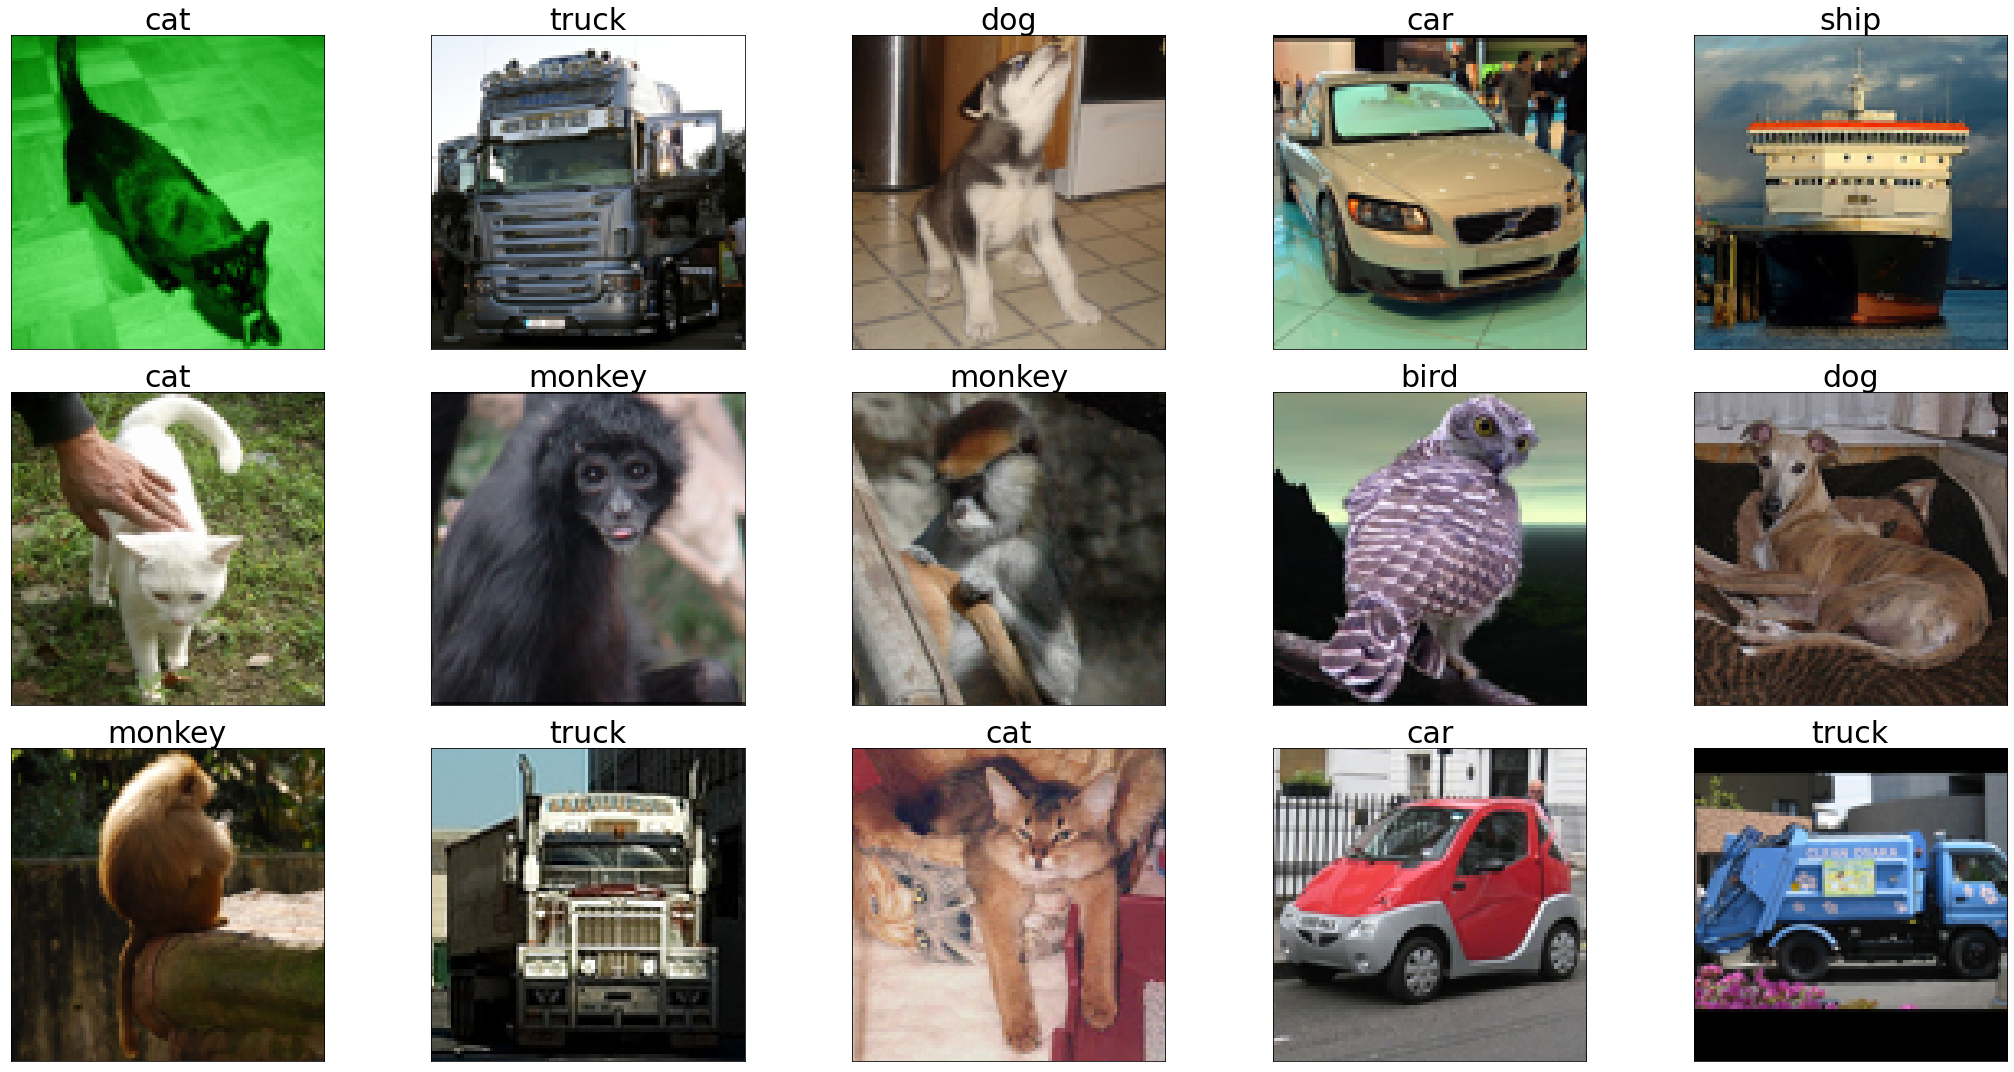

In [3]:
dataset = STL10(root='.', split='train', transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)
# get a single batch
for x, y in loader:
    break

# prepare visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={'size': 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"STL10 classes: {dataset.classes}")

As we can see, it's a little bit more realistic than 32x32 CIFAR-10. I won't use
function with training loop, I know that copying loop is less effective than 
creating a template, but It's a short notebook. In others notebooks I'll use a function.
Below, there is autoencoder definition. I took care of normalization. Generalization is the most important feature for me. Obvoiusly linear autoencoder isn't enough for such dataset, therefore I created CNN autoencoder.  Using small size of convolution is better, there are many papers, which say that. Autoencoder won't be used to generating images, so quality of generated images won't be
the most important sign to break training as generalization (for example truck with red tires on desert instead of normal truck on city road will be very imppresive). Last layer is a liitle bit too width, but the size of exactly 1000 will turn out helpful, beacuse resnet18 returns 1000-element tensor.

In [4]:
class ConvAutoencoder(nn.Module):
  def __init__(self):
        super(ConvAutoencoder, self).__init__()
        #Encoder
        self.encoder = torch.nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(32, device=device,track_running_stats=True),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(256, device=device,track_running_stats=True),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(256, 1000, 3, padding=1),
            nn.BatchNorm2d(1000, device=device,track_running_stats=True),
            nn.MaxPool2d(2,2)
          ).to(device)
        #Decoder
        self.decoder = torch.nn.Sequential(
            nn.ConvTranspose2d(1000, 256, 2, stride=2),
            nn.BatchNorm2d(256, device=device,track_running_stats=True),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.BatchNorm2d(32, device=device,track_running_stats=True),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(32, 3, 2, stride=2),
            #nn.Sigmoid()
          ).to(device)

  def decode(self, encoded):
    return self.decoder(encoded)

  def encode(self, x):
    return self.encoder(x)

  def forward(self, x):
    # encode and decode
    encoded = self.encode(x)
    decoded = self.decode(encoded)
    return encoded, decoded              

autoencoder = ConvAutoencoder().to(device)

#If colab braks, I have to upload saved model and continue training
upload_model = True
PATH_autoencoder = './autoencoderSTL10.pth'

if upload_model:
  autoencoder.load_state_dict(torch.load(PATH_autoencoder, map_location=device))


Here we have to load data. I use required normalization (if I had a chance to create whole model without pretrained resnet, I would compute best normalization for dataset before usage). Smaller batch size makes training too long, but improves generalization, therefore I was gradually deascreasing batch size. I started with 512. adamW amsgrad https://openreview.net/pdf?id=ryQu7f-RZ 

In [5]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
unlabeled_dataset = STL10(root='.', 
    split='unlabeled',
    download=True,
    transform=transform)


Files already downloaded and verified


In [6]:
batch_size = 1024
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size = batch_size, shuffle=True, num_workers=2)

Training lasted for 140 epochs with steps. It the future I'll use better loss
function (MSE here). I used SGD and ADAMW. As we know from for examle https://arxiv.org/pdf/1711.05101.pdf L2 regularization  and weight decay are equivalent for standard SGD, but not for ADAM and others with adaptive learning rate, therefore I used ADAMW (this problem is fixed). I also used SGD with both weight decay and momentum and propabbly it was my mistake, fortunately only for a few epochs.
1. At the beggining i used ADAMW LR = 0.001 betas=(0.9, 0.999),weight_decay=0.01 batch=512 for 10 epochs
2. Change batch to 256 for 80 epochs
3. Change learning rate to 0.0008 for 3 epochs
4. Change lr to 0.0005 for 7 epochs
5. Change optimizer to sgd, lr=0.0003, weight_decay=0.008,
momentum=0.005 for 3 epochs
6. Change lr to 0.0001 and set momentum to 0 for 2 epochs
8. Change batchsize to 1024 for 3 epochs
9. Change optimizer to adamw LR = 0.0003 betas=(0.9, 0.999),weight_decay=0.01 batch=1024 for 10 epochs
10. Change lr to 0.0001 and beta1 to 0.91 for 10 epochs
11. Change lr to 0.00005 and optimizer to SGD for 2 epochs

Finnally: 140 epochs

In [ ]:
epoch_no = 138

In [ ]:
epochs = 2
LR = 0.00005
autoencoder.to(device)
optimizer = torch.optim.SGD(autoencoder.parameters(), lr=LR, momentum=0,
              weight_decay=0.008)
#optimizer = torch.optim.AdamW(autoencoder.parameters(),
#            lr=LR,betas=(0.91, 0.999),weight_decay=0.01, amsgrad=True)
criterion1 = torch.nn.MSELoss() 
for epoch in range(epochs):
  autoencoder.train()
  epoch_losses = []  # For logging purposes
  for step, data in enumerate(unlabeled_loader):
      x, _ = data
      x = x.to(device)
      encoded, decoded = autoencoder(x) 
      loss_val = criterion1(decoded, x)
      optimizer.zero_grad()
      loss_val.backward()
      optimizer.step()
      
      epoch_losses.append(loss_val.item())
  autoencoder.eval()
  torch.save(autoencoder.state_dict(), PATH_autoencoder)
  epoch_no += 1
  print(f'Epoch: {epoch_no}  |  train loss: {np.mean(epoch_losses):.4f}')

Epoch: 139  |  train loss: 0.2385
Epoch: 140  |  train loss: 0.2386


Eventually I reach loss 0.2386. Autoencoder generates images as we can see below. It's perfect, but mind that is a part of bigger model and I won't be using autoencoder to generate new images, just to create sensible representation of these images. My previous architecture had lower loss, although quality of generated images was worse. I think It is because I did not pay attention to generalization (too big variance), in this model there are weight decay, dopout, batch normalization and others.

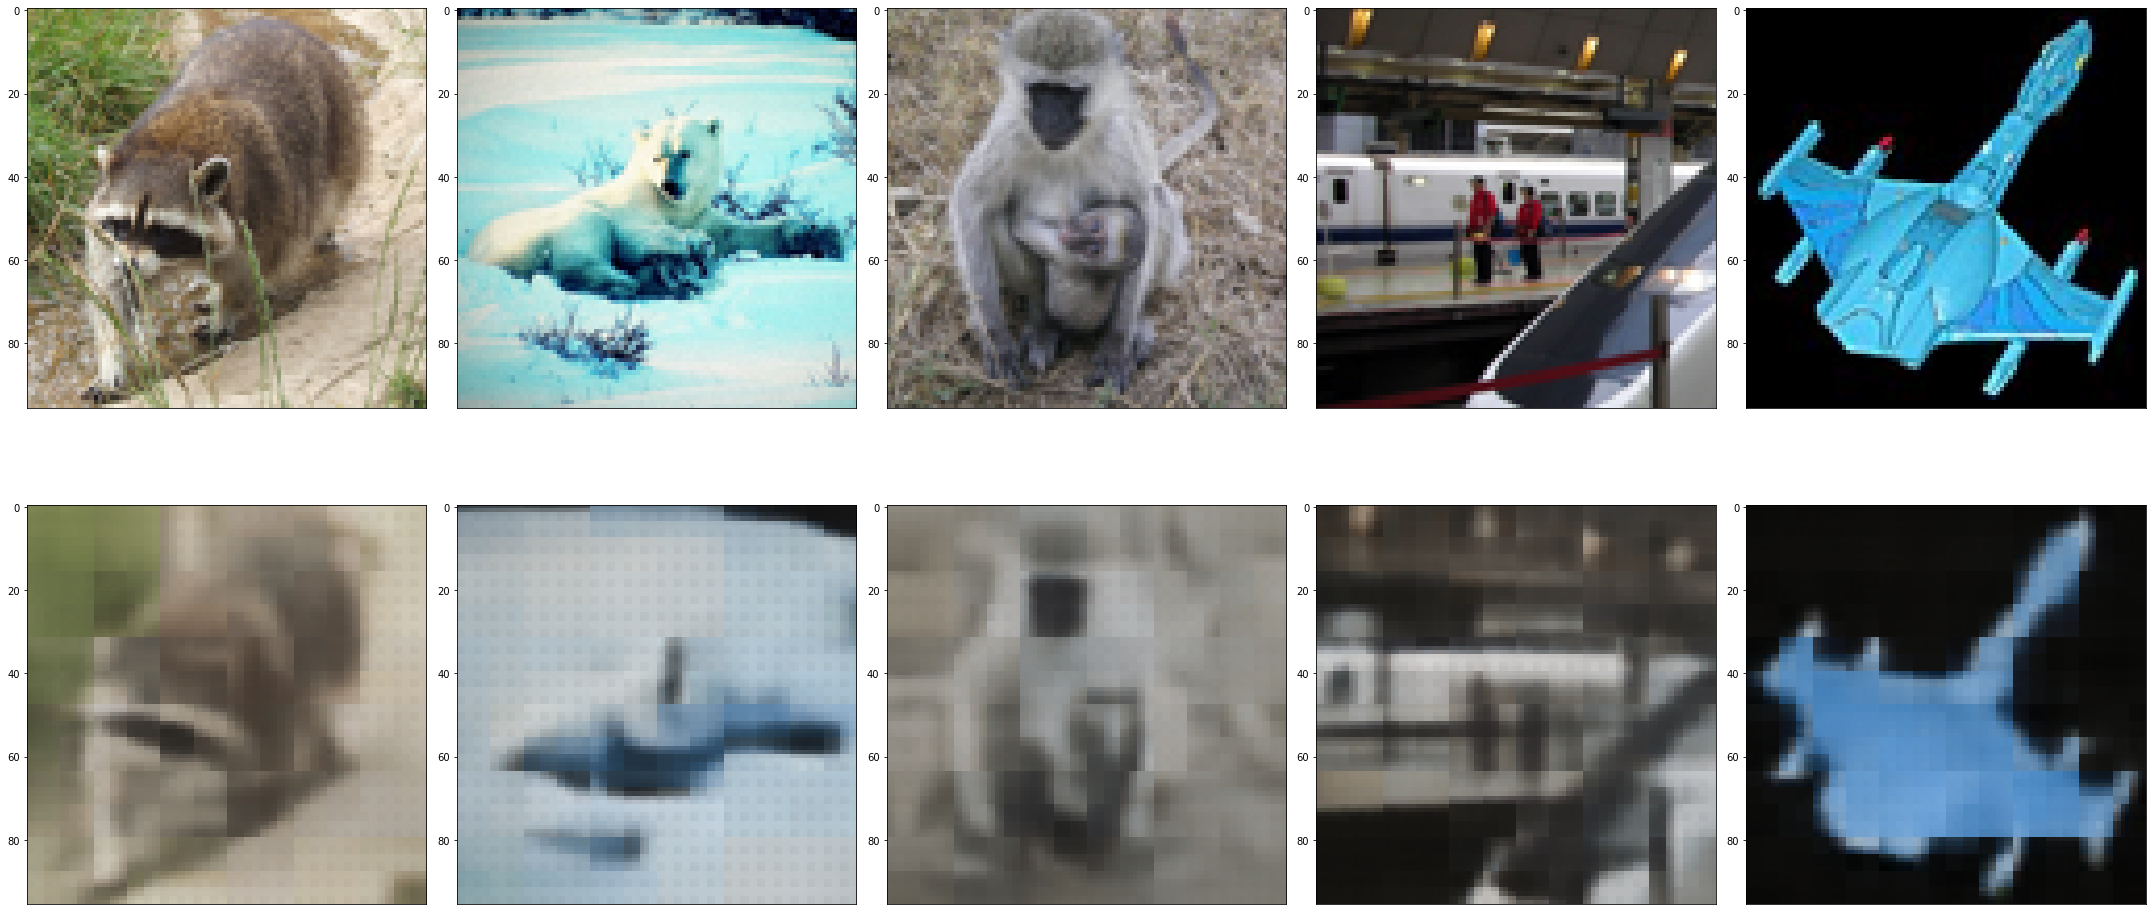

In [ ]:
autoencoder.eval()
iters = 1
#I was modyfing batch size during training so i need those loops
#to have enough images to create visualisation with fixed size.
for X,_ in unlabeled_loader:
  break
for data in unlabeled_loader:
  x, _ = data
  X = torch.cat([X,x],dim=0)
  iters = iters-1
  if iters == 0:
    break

X = X.to(device)
XX = torch.nn.functional.relu6(normalizeInverse(X)*6)/6
XX = XX.to("cpu")
with torch.no_grad():
  X = autoencoder(X)[1]
X = torch.nn.functional.relu6(normalizeInverse(X)*6)/6

X = X.to("cpu")
# Prepare visualisations
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
      if i == 0:
        ax.imshow(np.transpose(XX[j], (1, 2, 0)))
      else:
        ax.imshow(np.transpose(X[j], (1, 2, 0)))
      ax.set_xticks([])

fig.tight_layout()


Now, we may create out main model. It contains pretrained Resnet18 and our autoencoder. Autoencoder will be using only as an encoder with locked weights (it won't learn anymore). We throw combined tensor (Resnet18 and encoder results) to linear layers. Our network is large in some places, therefore we need a good normalization, especially bigger dropout in widest places.

In [7]:
from torchvision.models import resnet
import torchvision.models

class ModelAED(torch.nn.Module):
  def __init__(self, encoder, eps=1e-05):
    super(ModelAED, self).__init__()
    self.encoder = encoder
    self.resnet = torchvision.models.resnet18(pretrained=True)
    self.tgh = nn.Tanh()
    #We are not going to train representation bulider
    for param in encoder.parameters():
      param.requires_grad = False
    encoder.training = False
    for param in self.resnet.parameters():
      param.requires_grad = True
    
    
    self.avg = nn.AdaptiveAvgPool2d((1,1))
    self.lin_layers = torch.nn.Sequential(
        nn.BatchNorm1d(2000, track_running_stats=True, 
                       momentum=0.04, device=device),
        nn.Tanh(),
        nn.Dropout(p=0.32),
        nn.Linear(2000, 32),
        nn.BatchNorm1d(32, track_running_stats=True, 
                       momentum=0.04, device=device),
        nn.ReLU(),
        nn.Linear(32, 10)
    )

  def forward(self, x):
    self.resnet.training = self.training
    xR = self.resnet(x)
    xE = self.tgh(self.encoder.encode(x))
    xE = self.avg(xE)
    xE = torch.flatten(xE, 1)
    x = torch.cat([xE,xR], dim=1)
    x = self.lin_layers(x)
    return x

model = ModelAED(autoencoder).to(device)

upload_model = True
PATH_model = './modelAEDSTL.pth'

if upload_model:
  model.load_state_dict(torch.load(PATH_model, map_location=device))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Firstly, we'll try to train model without augmentation.

In [ ]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
transform_test=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = STL10(root='.', 
    split='train',
    download=True,
    transform=transform)

train_part = 0.89

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, 
  [round(5000*train_part), 5000 - round(5000*train_part)])

test_dataset = STL10(root='.', 
    split='test',
    download=True,
    transform=transform_test)

test_batch = 512

test_loader = DataLoader(test_dataset, batch_size=test_batch, shuffle=False, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=test_batch, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


We have to find best hyperparameters on validation dataset for ADAMw. We will use hyperparameters for ADAMw later, we assume that they will be good for any range of epochs (partial truth). It is a simplification and we may improve methods of finding them. There is one problem with finding the best batch size: after the same number of epochs lower batch size usually be better, beacause of more steps.

In [ ]:
lr_list = [0.0012/(math.pow(1.2,x)) for x in range(1,7)]
beta1_list = [0.9 + 0.01*x for x in range(-2,4)]
#momentum_list = [0.5+0.05*x for x in range(0,10)]
batch_size_list = [2**x for x in range(1,10)]

In [ ]:
#We K_rand times randomly choose hyperparameters from each list
#Then we go through ep_no epochs and write out hyperparameters with accuracy
K_rand = 20
ep_no = 3
criterion = nn.CrossEntropyLoss()
for i in range(K_rand):
  lr = random.choice(lr_list)
  #momentum = random.choice(momentum_list)
  beta1 = random.choice(beta1_list)
  batch_size = random.choice(batch_size_list)
  train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)
  model = ModelAED(autoencoder).to(device)
  #optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  optimizer = torch.optim.AdamW(model.parameters(),
            lr=lr,betas=(beta1, 0.999),weight_decay=0.01, amsgrad=True)
  model.train()
  for j in range(ep_no):
    for data in train_loader:
      x, y = data
      x, y = (x.to(device), y.to(device))
      out = model(x)
      optimizer.zero_grad()
      loss = criterion(out, y)
      loss.backward()
      optimizer.step()
  model.eval()
  with torch.no_grad():
    correct = 0
    batch_no = 0
    for x, y in val_loader:
      batch_no += 1
      x, y = (x.to(device), y.to(device))
      out = model(x)
      loss = criterion(out, y)
      result = out.argmax(dim = 1)
      for a, b in zip(result, y):
        if a == b:
          correct += 1
    print("loss %.3f accuracy %.2f %% batch_size %d lr %.5f beta1 %.2f" % 
                (loss/test_batch, correct/test_batch/batch_no*100,batch_size
                 ,lr, beta1))


loss 0.003 accuracy 38.87 % batch_size 256 lr 0.00100 beta1 0.90
loss 0.002 accuracy 38.28 % batch_size 16 lr 0.00058 beta1 0.93
loss 0.002 accuracy 44.73 % batch_size 256 lr 0.00058 beta1 0.90
loss 0.001 accuracy 44.14 % batch_size 64 lr 0.00040 beta1 0.88
loss 0.002 accuracy 40.72 % batch_size 32 lr 0.00040 beta1 0.91
loss 0.002 accuracy 35.74 % batch_size 128 lr 0.00100 beta1 0.89
loss 0.002 accuracy 40.33 % batch_size 64 lr 0.00048 beta1 0.92
loss 0.002 accuracy 35.16 % batch_size 8 lr 0.00069 beta1 0.93
loss 0.002 accuracy 37.11 % batch_size 16 lr 0.00100 beta1 0.88
loss 0.003 accuracy 19.04 % batch_size 4 lr 0.00069 beta1 0.92
loss 0.002 accuracy 46.58 % batch_size 512 lr 0.00058 beta1 0.92
loss 0.002 accuracy 40.33 % batch_size 32 lr 0.00048 beta1 0.93
loss 0.004 accuracy 10.16 % batch_size 2 lr 0.00069 beta1 0.92
loss 0.002 accuracy 44.92 % batch_size 256 lr 0.00069 beta1 0.93
loss 0.002 accuracy 33.01 % batch_size 64 lr 0.00083 beta1 0.92
loss 0.001 accuracy 45.80 % batch_size

As we can see the best hyperparameters are:
1. batch_size = 512
2. learning_rate = 0.00058
3. beta_1 = 0.92

In [ ]:
epoch_no = 0

In [ ]:
model = ModelAED(autoencoder).to(device)
upload_model = False
PATH_model = './modelAEDSTL.pth'
if upload_model:
  model.load_state_dict(torch.load(PATH_model, map_location=device))
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)

Training lasted for 21 epochs. I broke computation using early stopping mechanism (when the cost function has stabilized).

In [ ]:
n_epochs = 150
lr = 0.00058
beta1 = 0.92
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),
            lr=lr,betas=(beta1, 0.999),weight_decay=0.01, amsgrad=True)
train_loss_prev = 100
model.train()
for epoch in range(n_epochs):
  epoch_losses = []
  correct = 0
  cnt = 0
  for i, data in enumerate(train_loader, 0):
    cnt += 1
    x, y = data
    x, y = (x.to(device), y.to(device))
    out = model(x)
    optimizer.zero_grad()
    loss = criterion(out, y)
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
    result = out.argmax(dim = 1)
    for a, b in zip(result, y):
      if a == b:
        correct += 1
  epoch_no += 1
  mean_loss = np.mean(epoch_losses)
  print('Epoch: %d | train loss: %.4f | train accuracy: %.2f %%' %
    (epoch_no, mean_loss, correct/batch_size/cnt*100) )
  #early stopping
  if abs(mean_loss - train_loss_prev) < 0.015:
    print("EARLY STOPPING")
    break
  train_loss_prev = mean_loss
  torch.save(model.state_dict(), PATH_model)
model.eval()


Epoch: 1 | train loss: 1.6902 | train accuracy: 55.06 %
Epoch: 2 | train loss: 1.1516 | train accuracy: 86.74 %
Epoch: 3 | train loss: 0.9461 | train accuracy: 94.01 %
Epoch: 4 | train loss: 0.8232 | train accuracy: 95.99 %
Epoch: 5 | train loss: 0.7359 | train accuracy: 96.42 %
Epoch: 6 | train loss: 0.6653 | train accuracy: 96.53 %
Epoch: 7 | train loss: 0.6001 | train accuracy: 96.55 %
Epoch: 8 | train loss: 0.5439 | train accuracy: 96.57 %
Epoch: 9 | train loss: 0.4907 | train accuracy: 96.57 %
Epoch: 10 | train loss: 0.4449 | train accuracy: 96.57 %
Epoch: 11 | train loss: 0.4034 | train accuracy: 96.57 %
Epoch: 12 | train loss: 0.3666 | train accuracy: 96.57 %
Epoch: 13 | train loss: 0.3320 | train accuracy: 96.57 %
Epoch: 14 | train loss: 0.3024 | train accuracy: 96.57 %
Epoch: 15 | train loss: 0.2760 | train accuracy: 96.57 %
Epoch: 16 | train loss: 0.2515 | train accuracy: 96.57 %
Epoch: 17 | train loss: 0.2304 | train accuracy: 96.57 %
Epoch: 18 | train loss: 0.2107 | train a

ModelAED(
  (encoder): ConvAutoencoder(
    (encoder): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Dropout(p=0.2, inplace=False)
      (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): ReLU()
      (8): Dropout(p=0.2, inplace=False)
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): ReLU()
      (12): Dropout(p=0.2, inplace=False)
      (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      

Final model test. Model was trained without augmentation with accuracy 87.10% on test dataset.

In [ ]:
correct = 0
batches = 0
with torch.no_grad():
  for x, y in test_loader:
    x, y = (x.to(device), y.to(device))
    out = model(x)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(out, y)
    result = out.argmax(dim = 1)
    for a, b in zip(result, y):
      if a == b:
        correct += 1
    batches += 1
    
print("Test loss %.3f Accuracy %.2f %%" % 
      (loss, correct/test_batch/batches*100))

Test loss 0.567 Accuracy 87.10 %


I applied FGSM below. Translation above 0.02x is sensless in this case, beacuse
we can notice unnatural noise, but sometimes we consider bigger translation as well.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


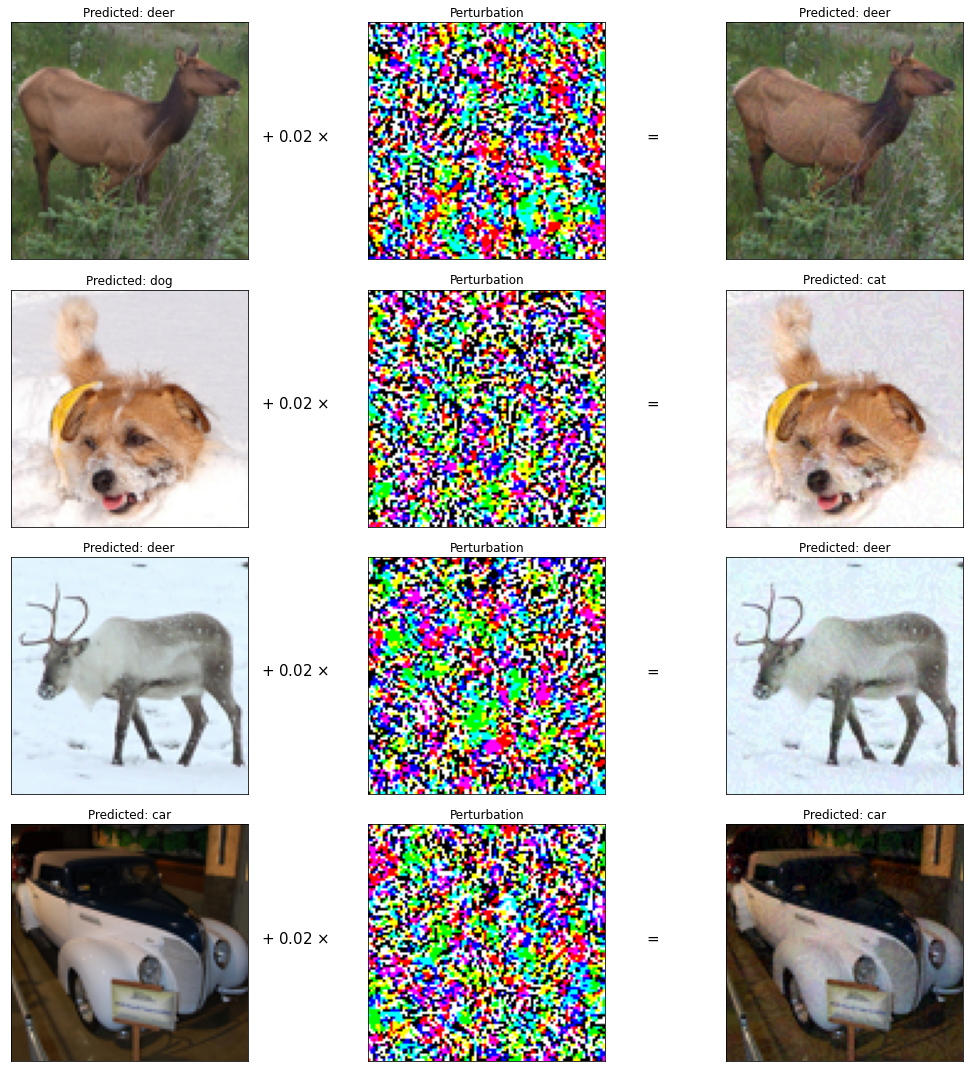

In [ ]:
def show_FGSM(x, y, eps = 0.02):
  # prepare loss function for the method
  loss = nn.CrossEntropyLoss()

  # inputs need to have gradients enabled!
  x.requires_grad = True

  # run the model and calculate the loss
  outputs = model(x)
  cost = loss(outputs, y)

  # get input gradients
  grad = torch.autograd.grad(cost, x, create_graph=False)[0]
  x.requires_grad = False

  # FGSM
  adv_imgs = x + eps * grad.sign()
  # clamp to the image range
  adv_imgs = torch.clamp(adv_imgs, min=0, max=1).detach()
  # save gradients for visualisation
  grads = torch.clamp(grad.sign(), min=0, max=1).detach()

  # run the advesarial samples through the network
  adv_imgs = adv_imgs.to(device)
  with torch.no_grad():
    output = model(adv_imgs)
  adv_pred = torch.argmax(output, 1)

  #Rzeczywiste przesuniecie
  x = normalizeInverse(x)
  adv_imgs = x + eps * grad.sign()

  adv_imgs = adv_imgs.to("cpu")
  x = x.to("cpu")
  y = y.to("cpu")
  adv_pred = adv_pred.to("cpu")
  output = output.to("cpu")
  grads = grads.to("cpu")


  # visualisation
  fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
  for row, img, adv, p, adv_p, g in zip(axes, x, adv_imgs, y, adv_pred, grads):
      row[0].imshow(np.transpose(img.detach(), (1,2,0)))
      row[0].set_title(f"Predicted: {test_dataset.classes[p]}")
      row[0].set_xticks([])
      row[0].set_yticks([])
      
      row[0].text(1.2,0.5, fr"+ {eps} $\times$", size=15, ha="center", transform=row[0].transAxes)
      
      row[1].imshow(np.transpose(g, (1,2,0)))
      row[1].set_title(f"Perturbation")
      row[1].set_xticks([])
      row[1].set_yticks([])
      
      row[1].text(1.2,0.5, "=", size=15, ha="center", transform=row[1].transAxes)
      
      row[2].imshow(np.transpose(adv.detach(), (1,2,0)))
      row[2].set_title(f"Predicted: {test_dataset.classes[adv_p]}")
      row[2].set_xticks([])
      row[2].set_yticks([])
      
  fig.tight_layout()

batch_no = 6
for step, data in enumerate(test_loader):
  x, y = data
  x, y = (x.to(device), y.to(device))
  if step == batch_no:
    break

show_FGSM(x,y, 0.02)

As we can see, the FGSM attack may cause a big accuracy deacrease. I wrote out accuracy for some FGSM values.

In [ ]:
#FGSM attack 


loss = nn.CrossEntropyLoss()
for t in range(10):
  for x, y in test_loader:
    x, y = (x.to(device), y.to(device))
    x.requires_grad = True
    out = model(x)
    cost = loss(out, y)
    grad = torch.autograd.grad(cost, x, create_graph=False)[0]
    x.requires_grad = False
    eps = 0.005*t
    adv_imgs = x + eps * grad.sign()
    adv_imgs.requires_grad = False
    out = model(adv_imgs)
    adv_pred = torch.argmax(out, 1)
    correct = 0
    for a, b in zip(adv_pred, y):
      if a == b:
        correct += 1
    print("dx = %.3f | Accuracy %.1f %%" % 
          (t*0.005, correct/test_batch*100))
    break
    


dx = 0.000 | Accuracy 89.1 %
dx = 0.005 | Accuracy 76.8 %
dx = 0.010 | Accuracy 60.7 %
dx = 0.015 | Accuracy 49.4 %
dx = 0.020 | Accuracy 38.9 %
dx = 0.025 | Accuracy 33.2 %
dx = 0.030 | Accuracy 29.3 %
dx = 0.035 | Accuracy 26.4 %
dx = 0.040 | Accuracy 22.9 %
dx = 0.045 | Accuracy 21.1 %


Now, we are going to apply Hedge Defence. It is based on the article https://arxiv.org/pdf/2106.04938.pdf. Algorithm prepares an image before It is thrown into the model, It is not a part of network. Hedge defence may decrease accuracy a little, but when image is adversarial prepared (attack), model should handle with it well and accuracy should be comaprable with natural images. We construct series, where x' is an input image with added Gaussian noise. In each itteration, we compute loss of all classes and move image in gradient direction, but with projection operator, which is protection against too far step. We have three hyperparameters:
1. K - iterations, which determine series length
2. ns - coefficient analogous to epsilon in FGSM
3. e_d - ball radius in projection

In [64]:
#Hedge defence

import torch.nn as nn

class HG_model(torch.nn.Module):
  def __init__(self, net, K=1, e_d=0.02, ns = 0.01):
    super(HG_model, self).__init__()
    self.net = net.to(device)
    self.e_d = e_d
    self.ns = ns
    self.K = K
    self.thr = nn.Threshold(-e_d, -e_d)
    self.criterion = nn.CrossEntropyLoss()
    self.net.training = False
    for param in self.net.parameters():
      param.requires_grad = False
  
  def projection(self, X1, X2):
    dif = X2 - X1
    XX = -torch.abs(dif)
    XX = -self.thr(XX)
    XX = X1 + torch.sign(dif)*XX
    return XX

  def forward(self, X):
    noise = torch.randn(X.shape, device=device)*2-1
    XX = X + self.e_d*noise
    for k in range(self.K):
      classes_tensor = torch.zeros(XX.shape[0], dtype=torch.uint8).to(device)
      loss = 0
      for class_no in range(10):
        XX.requires_grad = True
        loss = self.criterion(self.net(XX), classes_tensor) + loss
        grad = torch.autograd.grad(loss, XX, create_graph=False)[0]
        XX.requires_grad = False
        classes_tensor = classes_tensor + 1
        prev = XX
        XX = XX + self.ns*grad.sign()
        XX = self.projection(prev, XX)
    return self.net(XX)


Firstly, we will apply model with hedge defence mechanism to the dataset with normal images.

In [ ]:
#Iterations
K = 22
#Max step
r = 0.075
#Scale
cof = 0.000008

hg_model = HG_model(model,K, r, cof).to(device)
hg_model.eval()

for x, y in test_loader:
  x, y = (x.to(device), y.to(device))
  break

for i in range(2):
  out = hg_model(x)
  result = out.argmax(dim = 1)
  correct = 0
  for a, b in zip(result, y):
    if a == b:
      correct += 1
  print("Iterations: %d , Radius: %.3f , Graf_cof: %f  Accuracy %.1f %%" % 
        (K, r, cof, correct/test_batch*100))


Iterations: 22 , Radius: 0.075 , Graf_cof: 0.000008  Accuracy 87.1 %
Iterations: 22 , Radius: 0.075 , Graf_cof: 0.000008  Accuracy 87.5 %


As we can see, model reached accuracy comparable with model without hedge defence. It took a long time because of projection. I was trying to avoid applying my own function, beacuse in pytorch they are computed on CPU only, therefore projection process is written in illegible way. We are checking the accuracy on dataset with adversarial prepared images.  

In [ ]:
loss = nn.CrossEntropyLoss()
for t in range(1,10):
  for x, y in test_loader:
    x, y = (x.to(device), y.to(device))
    x.requires_grad = True
    out = model(x)
    cost = loss(out, y)
    grad = torch.autograd.grad(cost, x, create_graph=False)[0]
    x.requires_grad = False
    eps = 0.005*t
    adv_imgs = x + eps * grad.sign()
    adv_imgs.requires_grad = False
    out = hg_model(adv_imgs)
    adv_pred = torch.argmax(out, 1)
    correct = 0
    for a, b in zip(adv_pred, y):
      if a == b:
        correct += 1
    print("dx = %.3f | Accuracy %.1f %%" % 
          (t*0.005, correct/test_batch*100))
    break
    


dx = 0.005 | Accuracy 82.2 %
dx = 0.010 | Accuracy 73.4 %
dx = 0.015 | Accuracy 65.2 %
dx = 0.020 | Accuracy 58.2 %
dx = 0.025 | Accuracy 50.6 %
dx = 0.030 | Accuracy 42.6 %
dx = 0.035 | Accuracy 38.5 %
dx = 0.040 | Accuracy 33.0 %
dx = 0.045 | Accuracy 30.1 %


Now we should train model with augmented data. It will probably increase accuracy on adversarial images, bacause of better generalization and bigger robustness. Below we transform data.

In [27]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomGrayscale(0.1),
    transforms.RandomHorizontalFlip(0.1),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 4)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
transform_test=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = STL10(root='.', 
    split='train',
    download=True,
    transform=transform)

test_dataset = STL10(root='.', 
    split='test',
    download=True,
    transform=transform_test)

test_batch = 512

test_loader = DataLoader(test_dataset, batch_size=test_batch, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Loading parameters from our previous model or loading last
save.

In [66]:
PATH_modelAUG = './modelAED_AUG_STL.pth'
modelAUG = ModelAED(autoencoder).to(device)
upload_model = False
if upload_model == True:
  modelAUG.load_state_dict(torch.load(PATH_modelAUG, map_location=device))
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)

In [67]:
epoch_no = 0

In [68]:
n_epochs = 40
lr = 0.00058
beta1 = 0.92
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(modelAUG.parameters(),
            lr=lr,betas=(beta1, 0.999),weight_decay=0.01, amsgrad=True)
modelAUG.train()
for epoch in range(n_epochs):
  epoch_losses = []
  correct = 0
  cnt = 0
  for i, data in enumerate(train_loader, 0):
    cnt += 1
    x, y = data
    x, y = (x.to(device), y.to(device))
    out = modelAUG(x)
    optimizer.zero_grad()
    loss = criterion(out, y)
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
    result = out.argmax(dim = 1)
    for a, b in zip(result, y):
      if a == b:
        correct += 1
  epoch_no += 1
  mean_loss = np.mean(epoch_losses)
  acc = correct/batch_size/cnt*100
  print('Epoch: %d | train loss: %.4f | train accuracy: %.2f %%' %
    (epoch_no, mean_loss, acc) )
  torch.save(modelAUG.state_dict(), PATH_modelAUG)

modelAUG.eval()


Epoch: 1 | train loss: 1.7635 | train accuracy: 48.54 %
Epoch: 2 | train loss: 1.2445 | train accuracy: 76.21 %
Epoch: 3 | train loss: 1.0391 | train accuracy: 84.88 %
Epoch: 4 | train loss: 0.8855 | train accuracy: 90.49 %
Epoch: 5 | train loss: 0.7796 | train accuracy: 92.85 %
Epoch: 6 | train loss: 0.6860 | train accuracy: 94.47 %
Epoch: 7 | train loss: 0.6100 | train accuracy: 95.18 %
Epoch: 8 | train loss: 0.5433 | train accuracy: 95.74 %
Epoch: 9 | train loss: 0.4849 | train accuracy: 96.13 %
Epoch: 10 | train loss: 0.4323 | train accuracy: 96.21 %
Epoch: 11 | train loss: 0.3974 | train accuracy: 96.11 %
Epoch: 12 | train loss: 0.3646 | train accuracy: 95.98 %
Epoch: 13 | train loss: 0.3300 | train accuracy: 96.00 %
Epoch: 14 | train loss: 0.3009 | train accuracy: 96.17 %
Epoch: 15 | train loss: 0.2956 | train accuracy: 95.23 %
Epoch: 16 | train loss: 0.2597 | train accuracy: 95.82 %
Epoch: 17 | train loss: 0.2461 | train accuracy: 95.94 %
Epoch: 18 | train loss: 0.2237 | train a

ModelAED(
  (encoder): ConvAutoencoder(
    (encoder): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Dropout(p=0.2, inplace=False)
      (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): ReLU()
      (8): Dropout(p=0.2, inplace=False)
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): ReLU()
      (12): Dropout(p=0.2, inplace=False)
      (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      

Checking accuracy on test dataset.

In [69]:
correct = 0
batches = 0
with torch.no_grad():
  for x, y in test_loader:
    x, y = (x.to(device), y.to(device))
    out = modelAUG(x)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(out, y)
    result = out.argmax(dim = 1)
    for a, b in zip(result, y):
      if a == b:
        correct += 1
    batches += 1
    
print("Test loss %.3f Accuracy %.2f %%" % 
      (loss, correct/test_batch/batches*100))

Test loss 0.638 Accuracy 82.58 %


In [70]:
#FGSM attack 

loss = nn.CrossEntropyLoss()
for t in range(10):
  for x, y in test_loader:
    x, y = (x.to(device), y.to(device))
    x.requires_grad = True
    out = modelAUG(x)
    cost = loss(out, y)
    grad = torch.autograd.grad(cost, x, create_graph=False)[0]
    x.requires_grad = False
    eps = 0.005*t
    adv_imgs = x + eps * grad.sign()
    adv_imgs.requires_grad = False
    out = modelAUG(adv_imgs)
    adv_pred = torch.argmax(out, 1)
    correct = 0
    for a, b in zip(adv_pred, y):
      if a == b:
        correct += 1
    print("dx = %.3f | Accuracy %.1f %%" % 
          (t*0.005, correct/test_batch*100))
    break
    



dx = 0.000 | Accuracy 82.0 %
dx = 0.005 | Accuracy 65.4 %
dx = 0.010 | Accuracy 56.4 %
dx = 0.015 | Accuracy 49.2 %
dx = 0.020 | Accuracy 42.4 %
dx = 0.025 | Accuracy 40.4 %
dx = 0.030 | Accuracy 38.1 %
dx = 0.035 | Accuracy 36.7 %
dx = 0.040 | Accuracy 35.9 %
dx = 0.045 | Accuracy 35.2 %


Result is worse than model which was trained on non-augmented dataset and takes hedge prepared data. Let's try use a Hedge Defence on it.

In [72]:
#Jest nawet gorzej, ale zastosujmy hedge defence

#Iteracje
K = 28
#Maksymalny krok
r = 0.08
#Skalowanie gradientu
cof = 0.000003

hg_model = HG_model(modelAUG,K, r, cof).to(device)
hg_model.eval()


loss = nn.CrossEntropyLoss()
for t in range(1,10):
  for x, y in test_loader:
    x, y = (x.to(device), y.to(device))
    x.requires_grad = True
    out = modelAUG(x)
    cost = loss(out, y)
    grad = torch.autograd.grad(cost, x, create_graph=False)[0]
    x.requires_grad = False
    eps = 0.005*t
    adv_imgs = x + eps * grad.sign()
    adv_imgs.requires_grad = False
    out = hg_model(adv_imgs)
    adv_pred = torch.argmax(out, 1)
    correct = 0
    for a, b in zip(adv_pred, y):
      if a == b:
        correct += 1
    print("dx = %.3f | Accuracy %.1f %%" % 
          (t*0.005, correct/test_batch*100))
    break
    


dx = 0.005 | Accuracy 72.1 %
dx = 0.010 | Accuracy 67.2 %
dx = 0.015 | Accuracy 60.7 %
dx = 0.020 | Accuracy 56.6 %
dx = 0.025 | Accuracy 52.0 %
dx = 0.030 | Accuracy 45.7 %
dx = 0.035 | Accuracy 43.6 %
dx = 0.040 | Accuracy 41.4 %
dx = 0.045 | Accuracy 40.2 %


# Conclusion
Hedge defence helps a lot against FGSM attacks, increases accuracy above 20% for any sensible range of attack. Augmentation training is worse even with hedge defence. It is chance that autoencoder (which is a part of the main model) trained on augmented data would improve results. My model was specific, but for "typical" models augmentation training could improve defence.